# TP3 CORRECTION - Apprentissage supervisé (classification multiclasse)

    cours: Master SIAD
    date: 25.10.2019
    @: vasseur.corentin@gmail.com

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

# modelisation scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# baseline cnn model for mnist
import numpy as np
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.optimizers import SGD

# display archi network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import confusion_matrix,precision_score
from utils_mnist import plot_confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# Partie 1 : MNIST

## 1.1. Charger des données et normaliser

In [2]:
# Quelques fonctions
from keras.datasets import mnist
from keras.utils import to_categorical

def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [3]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
trainX.shape

(60000, 28, 28, 1)

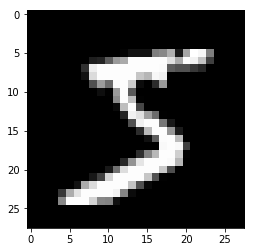

In [4]:
# Afficher une image
plt.imshow(trainX[0][:,:,0], cmap='gray')

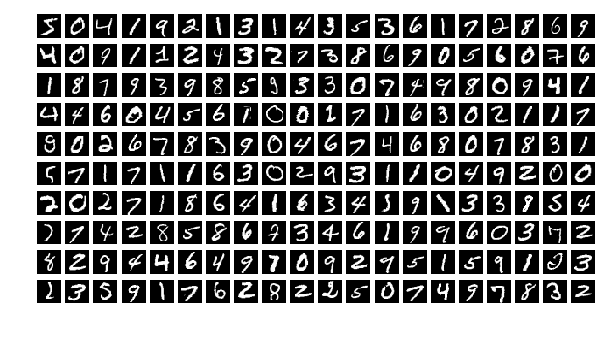

In [5]:
# Afficher les 200 premières images

plt.figure(figsize=(7.195, 3.841), dpi=100)
for i in range(200):
    plt.subplot(10,20,i+1)
    plt.imshow(trainX[i,:].reshape([28,28]), cmap='gray')
    plt.axis('off')
plt.show()

## 1.2 Modélisation scikit-learn: KNN 

In [6]:
# on choisit le nombre d'hyperparamètres du modèle (3 plus proches voisins ici)
clf = KNeighborsClassifier(n_neighbors=3)

# Reshape images en vecteurs de 784 pixels (28x28)
train_x = trainX.reshape(60000,784)
train_y = trainY

print("Train model:")
clf.fit(train_x, train_y)

# Test on the next 100 images:
test_x = testX.reshape(10000,784)[:1000]
expected = testY[:1000]

print("Compute predictions:")
predicted = clf.predict(test_x)

print("Accuracy: ", accuracy_score(expected, predicted))

Train model:
Compute predictions:
Accuracy:  0.961


# Partie 2 et 3 : Les réseaux de neurones

In [7]:
def define_perceptron_multicouche():
    model = Sequential()
    model.add(Dense(784, activation='relu', input_shape=(784,)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9) # optimiser method
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def define_convolutif_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9) #optimiser method
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## 2.1. Perceptron multi-couches

In [8]:
# définir le modèle et phase d'apprentissage

model_PMC = define_perceptron_multicouche()
model_PMC.fit(trainX.reshape(60000,784), 
              trainY, 
              epochs=10, 
              batch_size=32,
              validation_data=(testX.reshape(10000,784), testY), 
              verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.2444 - acc: 0.9267 - val_loss: 0.1274 - val_acc: 0.9612
Epoch 2/10
60000/60000 [==============================] - 10s 165us/step - loss: 0.0967 - acc: 0.9707 - val_loss: 0.0817 - val_acc: 0.9736
Epoch 3/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.0618 - acc: 0.9810 - val_loss: 0.0802 - val_acc: 0.9747
Epoch 4/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0434 - acc: 0.9868 - val_loss: 0.0820 - val_acc: 0.9742
Epoch 5/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0311 - acc: 0.9907 - val_loss: 0.0578 - val_acc: 0.9820
Epoch 6/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0219 - acc: 0.9936 - val_loss: 0.0660 - val_acc: 0.979

In [9]:
# prédiction sur l'échantillon test
predicted = model_PMC.predict(testX.reshape(10000,784))

    Estimation des performances du modèle (matrice de confusion) :

In [10]:
y_pred, y_true = list(), list()

# valeurs prédites
for i in predicted:
    maxi = max([round(j) for j in i])
    y_pred.append(int([round(j) for j in i].index(maxi)))

# valeurs réelles
for i in testY:
    y_true.append(int(list(i).index(1)))

Confusion matrix, without normalization
[[ 971    0    1    0    2    0    1    0    3    2]
 [   1 1128    1    1    0    1    2    1    0    0]
 [   5    1 1011    3    3    0    1    5    3    0]
 [   3    0    2  994    0    1    0    2    4    4]
 [   2    0    2    1  966    0    2    1    0    8]
 [   3    0    0    9    1  873    3    0    2    1]
 [   3    3    0    1    6    2  940    0    3    0]
 [   2    1    4    1    3    0    0 1006    5    6]
 [   4    0    1    2    1    1    2    2  959    2]
 [   5    2    0    2   12    2    1    4    1  980]]


<Figure size 1440x1440 with 0 Axes>

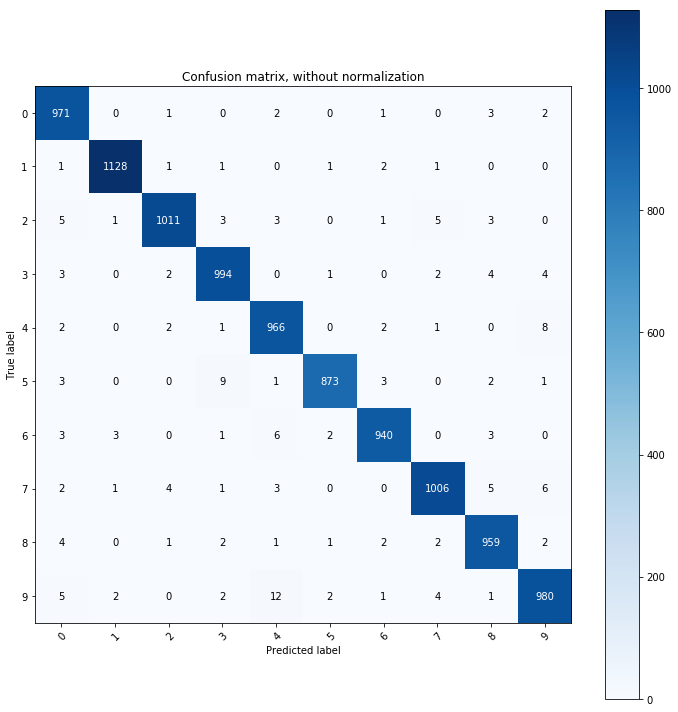

In [11]:
# calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_true, y_pred)

# display confusion matrix
plt.figure(figsize=(20, 20))
plot_confusion_matrix(y_true, y_pred, classes=np.unique(y_pred), normalize=False)

In [12]:
# Architecture du modèle PMC :
model_PMC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,022,490
Trainable params: 1,022,490
Non-trainable params: 0
_________________________________________________________________


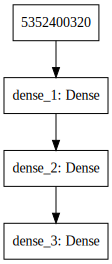

In [13]:
SVG(model_to_dot(model_PMC).create(prog='dot', format='svg'))

## 2.2 Réseau neuronal convolutif

In [14]:
model_CONV = define_convolutif_model()
model_CONV.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s 304us/step - loss: 0.2986 - acc: 0.9100 - val_loss: 0.0844 - val_acc: 0.9739
Epoch 2/10
60000/60000 [==============================] - 18s 296us/step - loss: 0.0788 - acc: 0.9766 - val_loss: 0.0566 - val_acc: 0.9829
Epoch 3/10
60000/60000 [==============================] - 18s 306us/step - loss: 0.0544 - acc: 0.9839 - val_loss: 0.0472 - val_acc: 0.9854
Epoch 4/10
60000/60000 [==============================] - 18s 296us/step - loss: 0.0422 - acc: 0.9880 - val_loss: 0.0446 - val_acc: 0.9859
Epoch 5/10
60000/60000 [==============================] - 18s 294us/step - loss: 0.0344 - acc: 0.9899 - val_loss: 0.0386 - val_acc: 0.9877
Epoch 6/10
60000/60000 [==============================] - 18s 298us/step - loss: 0.0284 - acc: 0.9920 - val_loss: 0.0363 - val_acc: 0.9884
Epoch 7/10
60000/60000 [==============================] - 17s 289us/step - loss: 0.0240 - acc: 0.9929 - val_loss: 0.

In [15]:
model_CONV.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total para

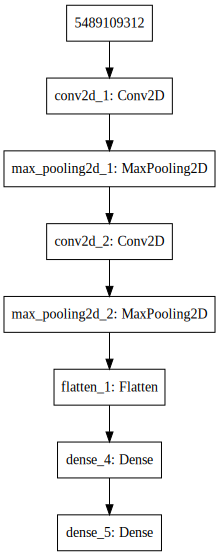

In [16]:
# SVG permettant d'afficher graphiquement le réseau de neurones
SVG(model_to_dot(model_CONV).create(prog='dot', format='svg'))

In [17]:
# prédiction sur les données test
predicted = model_CONV.predict(testX)

y_pred, y_true = list(), list()

# valeurs prédites (max du résultat de la dernière couche)
for i in predicted:
    maxi = max([round(j) for j in i])
    y_pred.append(int([round(j) for j in i].index(maxi)))
    
# valeurs réelles
for i in testY:
    y_true.append(int(list(i).index(1)))

Confusion matrix, without normalization
[[ 976    0    0    0    0    0    0    3    1    0]
 [   2 1127    1    2    0    0    1    2    0    0]
 [   6    0 1017    0    0    0    0    7    2    0]
 [   0    0    1 1002    0    4    0    2    1    0]
 [   0    0    2    0  969    0    1    0    0   10]
 [   2    0    0    5    0  882    2    1    0    0]
 [   7    2    0    1    1    4  943    0    0    0]
 [   0    2    3    3    0    0    0 1016    1    3]
 [   4    0    2    3    0    1    0    1  957    6]
 [   1    0    0    1    3    3    0    3    0  998]]


<Figure size 1440x1440 with 0 Axes>

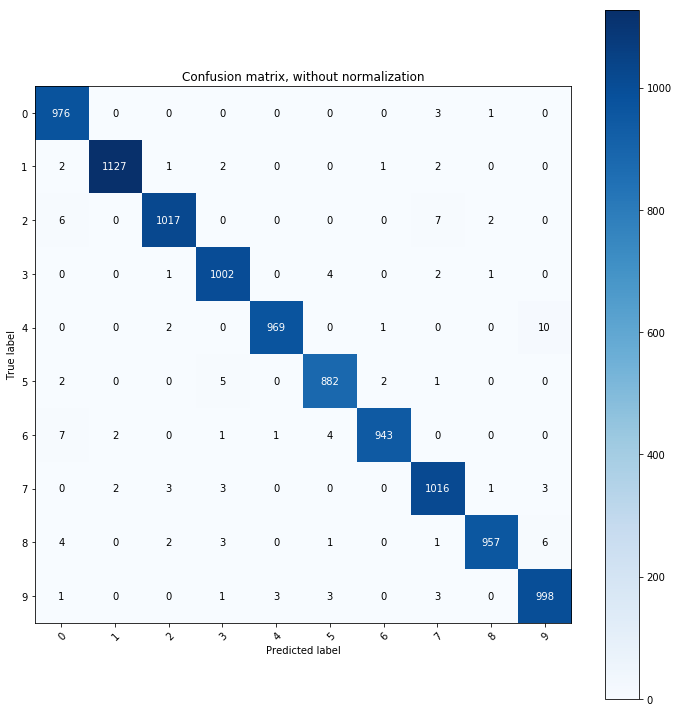

In [18]:
# calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_true, y_pred)

# display confusion matrix
plt.figure(figsize=(20, 20))
plot_confusion_matrix(y_true, y_pred, classes=np.unique(y_pred), normalize=False)



### 2.3 Estimation et comparaison des performances des 3 algorithmes sur les dernières images de l'échantillon test

In [19]:
y_pred_Knn = clf.predict(testX.reshape(10000,784)[-1000:])

y_pred=list()
for i in y_pred_Knn:
    maxi = max([round(j) for j in i])
    y_pred.append(int([round(j) for j in i].index(maxi)))
    

print('KNN: ', precision_score(y_pred, y_true[-1000:], average='weighted'))

KNN:  0.9717079516391537


In [20]:
y_pred=list()
for i in model_PMC.predict(testX.reshape(10000,784)[-1000:]):
    maxi = max([round(j) for j in i])
    y_pred.append(int([round(j) for j in i].index(maxi)))
print('PMC: ', precision_score(y_pred, y_true[-1000:], average='weighted'))


PMC:  0.9851169224211423


In [21]:
y_pred=list()
for i in model_CONV.predict(testX[-1000:]):
    maxi = max([round(j) for j in i])
    y_pred.append(int([round(j) for j in i].index(maxi)))

print('RCONV: ', precision_score(y_pred, y_true[-1000:], average='weighted'))

RCONV:  0.9881654021028702
